# Project Name : Bank Telemarketing Analysis

In [ ]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
import statsmodels
import scipy.stats as stats
import statsmodels.stats.proportion as smpt
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,accuracy_score, classification_report,f1_score,cohen_kappa_score

## Part 1 Project Background

### Nowadays, marketing expenditures in the banking industry are massive, meaning that it is essential for banks to optimize marketing strategies and improve effectiveness. Understanding customers’ need leads to more effective marketing plans, smarter product designs and greater customer satisfaction.

### Main Objectives: predict customers' responses to future marketing campaigns & increase the effectiveness of the bank's telemarketing campaign

### This project will enable the bank to develop a more granular understanding of its customer base, predict customers' response to its telemarketing campaign and establish a target customer profile for future marketing plans.

### By analysing customer features, such as demographics and transaction history, the bank will be able to predict customer saving behaviours and identify which type of customers is more likely to make term deposits. The bank can then focus its marketing efforts on those customers. This will not only allow the bank to secure deposits more effectively but also increase customer satisfaction by reducing undesirable advertisements for certain customers.

## Part 2 About the Data
### There are 45,211 observations in the dataset, with no missing values. Each represents an existing customer that the bank reached via phone calls. For each observation, the dataset records 17 input variables that stand for both qualitative and quantitative attributes of the customers. There is a single binary output variable that denotes “yes”(1) or “no(0)” revealing the outcomes of the marketing phone calls. "Yes" means that a customer subscribed to term deposits

In [ ]:
d1=pd.read_csv('../input/bankmarketing/Bank Marketing Data Set.csv')

In [ ]:
d1.isnull().sum()

## Part 3 Data Cleaning
### Several changes were made to the dataset to prepare it for analysis. There are unknown values for many variables in the data set which can be seen in the below plots. Variables with unknown/missing values are: 'education', 'job', 'poutcome', 'contact'. By observing these features, we found way of doing an imputation where we use other independent variables to infer the value of the missing variable. 

### Therefore, we start with creating new variables for the unknown values in 'education', 'job'. We do this to see if the values are missing at random or is there a pattern in the missing values.


In [ ]:
num_col = ['int16','int32','int64','float16','float32','float64']

#Filter out variables with numeric datatypes
df_numcols_only= d1.select_dtypes(include= num_col)

In [ ]:
cat_col=['object']
df_catcols_only=d1.select_dtypes(include=cat_col)

In [ ]:
for col in df_catcols_only:
    plt.figure(figsize=(10,4))
    sns.barplot(d1[col].value_counts().values, d1[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

## 3.1 Imputation:
### Now, to infer the missing values in 'job' and 'education', we make use of the cross-tabulation between 'job' and 'education'. Our hypothesis here is that 'job' is influenced by the 'education' of a person.

### Hence, we can infer 'job' based on the education of the person. Moreover, since we are just filling the missing values, we are not much concerned about the causal inference. We, therefore, can use the job to predict the education.

### Inferring education from jobs : From the cross-tabulation, it can be seen that people with management jobs usually have a university degree. Hence wherever 'job' = management and 'education' = unknown, we can replace 'education' with ‘tertiary'. Similarly, 'job' = 'services' --> 'education' = ‘secondary and 'job' = 'housemaid' --> 'education' = ‘primary.

### Inferring jobs from age : As we see, if 'age' > 60, then the 'job' is 'retired,' which makes sense.

### While imputing the values for job and education, we were cognizant of the fact that the correlations should make real world sense. If it didn't make real world sense, we didn't replace the missing values. We haven’t found such any hidden pattern between poutcome and contact and we haven’t changed unknowns in these features. Change the "response" variable (yes/no) to binary values (1/0) for easier analysis.

## Creating new variables (variable name + '_un') to capture the information if the missing values are at random or is there a pattern in the missing values.

In [ ]:
significant_cat_variables = ['education','job']
for var in significant_cat_variables:
    #df[var + '_un'] = 0
    #df[var + '_un'][df[var]=='unknown'] = 1
    #FIXME one-line coding
    d1[var + '_un'] = (d1[var] == 'unknown').astype(int)

In [ ]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

In [ ]:
cross_tab(d1,'job','education')

In [ ]:
d1.loc[(d1['age']>60) & (d1['job']=='unknown'),'job']='retired'
d1.loc[(d1['education']=='unknown') & (d1['job']=='admin.'), 'education'] = 'secondary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='blue-collar'), 'education'] = 'secondary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='entrepreneur'), 'education'] = 'tertiary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='housemaid'), 'education'] =  'primary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='management'), 'education'] = 'tertiary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='retired'), 'education'] = 'secondary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='self-employed'), 'education'] = 'tertiary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='services'), 'education'] = 'secondary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='student'), 'education'] = 'secondary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='technician'), 'education'] = 'secondary'
d1.loc[(d1['education']=='unknown') & (d1['job']=='unemployed'), 'education'] = 'secondary'

In [ ]:
cross_tab(d1,'job','education')

In [ ]:
d1.loc[(d1['education']=='unknown') & (d1['job']=='unknown'), 'education'] = 'secondary'

In [ ]:
d1.loc[(d1['education']=='secondary') & (d1['job']=='unknown'), 'job'] = 'blue-collar'
d1.loc[(d1['education']=='tertiary') & (d1['job']=='unknown'), 'job'] = 'blue-collar'
d1.loc[(d1['education']=='primary') & (d1['job']=='unknown'), 'job'] = 'management'

In [ ]:
cross_tab(d1,'job','education')

In [ ]:
d1['pdays'].replace(to_replace=-1,value=0,inplace=True)

In [ ]:
d1.rename(columns={'class':'deposit','campain':'campaign'},inplace=True)

In [ ]:
d1['deposit'].replace(to_replace=[1,2],value=[0,1],inplace=True)

## Part 4 Exploratory Data Analysis
## 4.1 Bivariate Analysis

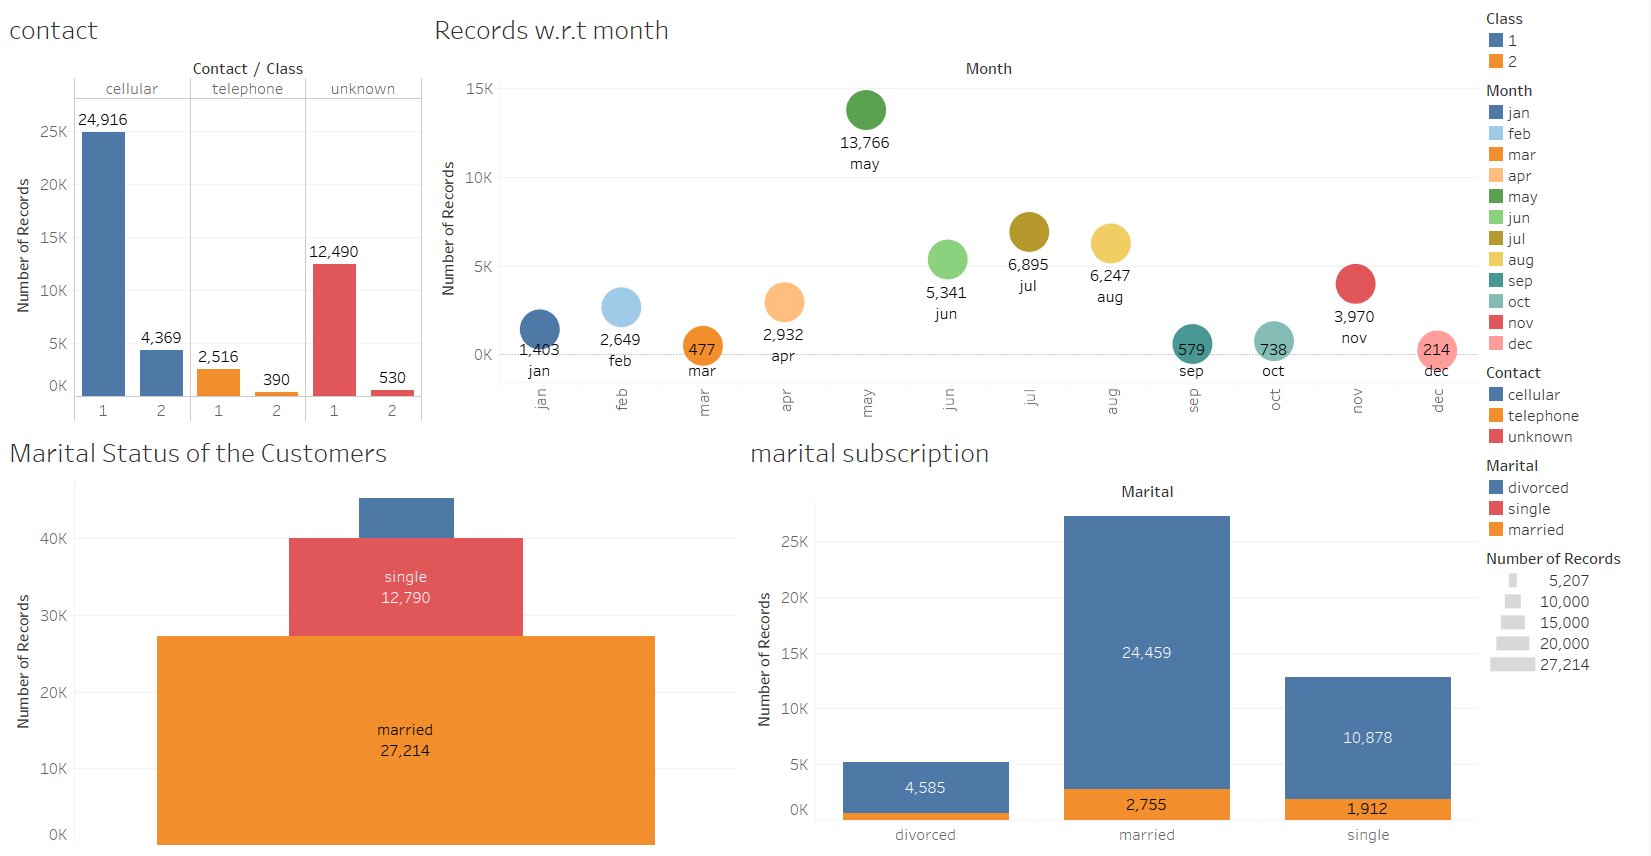

### The contact plot signifies that most of the people were contacted by the bank through cellular network more than 25,000 and among them more than 4,000 people have subscribed term deposit. From this we can infer that the bank should focus on the people who are available to contact them on cellular network.

### Even unknown contact type records are also of high number approximately 12,400. So, bank should take some initiatives to identify which contact type those unknowns are using and separate them into cellular, telephone or make a new cluster.

### We noticed a hidden pattern from “Records with respect time plot”. Majority of the records were identified in the month may followed by April, November and others. Similarly, lowest records were identified in the months March, December, June and others.  So, bank should not focus directly on the months which are having highest records instead of that they have to focus on the months at which most the subscriptions happening.


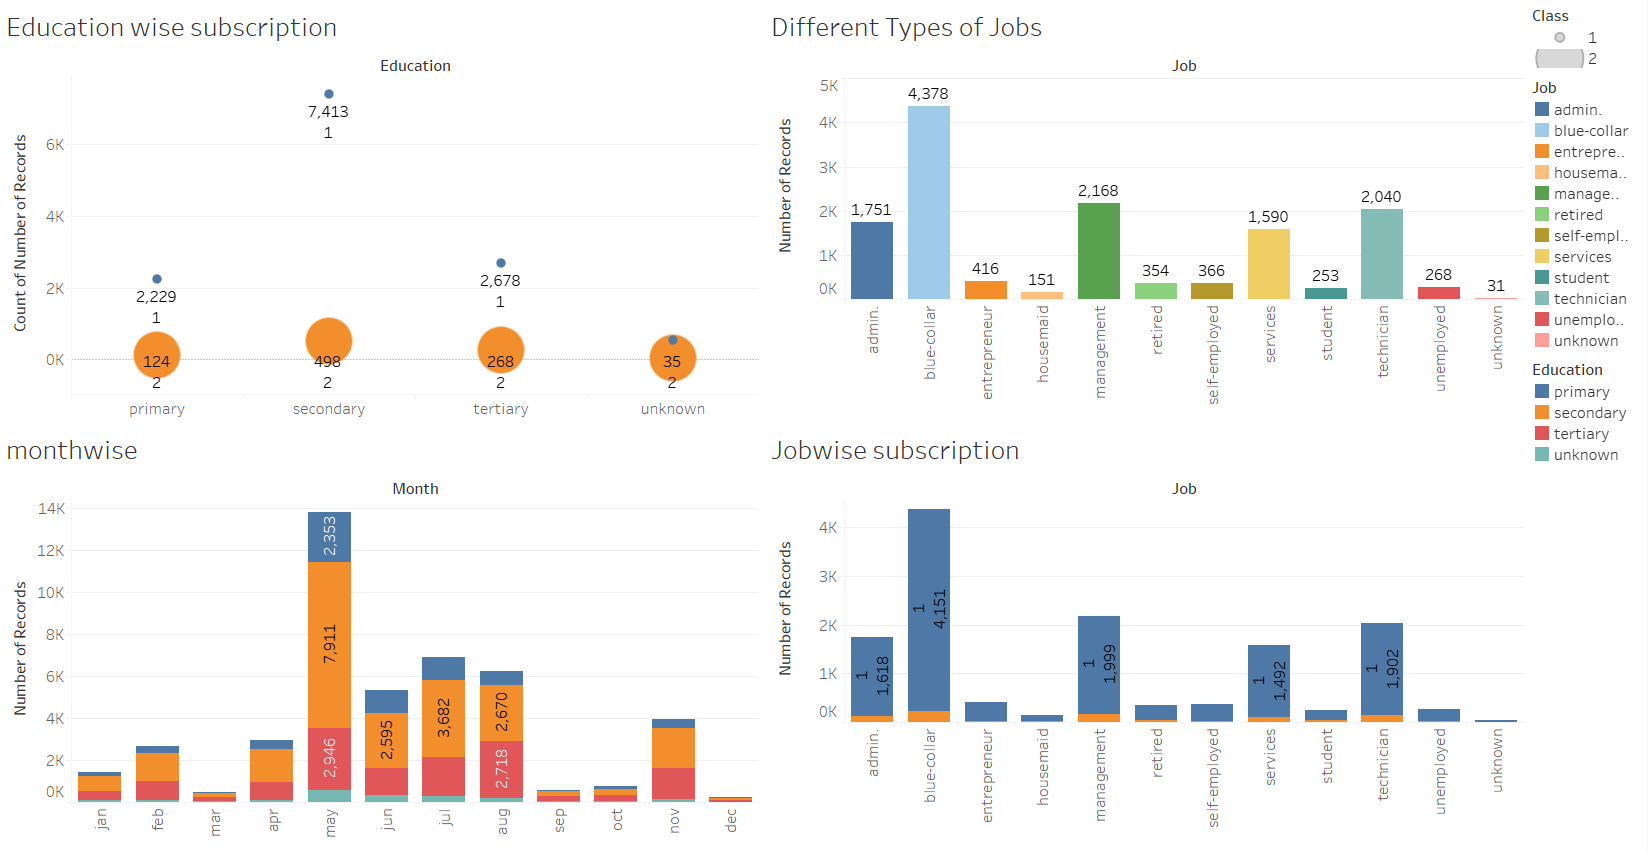

### In the given data it is observed that there are three types of educated people (primary, secondary, tertiary) and unknown. Among these secondary educated people are doing more subscriptions followed by tertiary, primary. So, the bank should focus their marketing on the tertiary educated people first and in the month of the may followed by other months. 

### In the given data it is observed that there are different types of jobs such as admin, management, student, blue collar and others. Among these blue collar job records are high approximately 4,000 and subscription wise also blue collar job holders are doing more term deposits. This signifies that bank should focus on doing marketing on blue collar job holder’s followed by management, admin, and others which leads to good number of the people turn towards subscriptions.

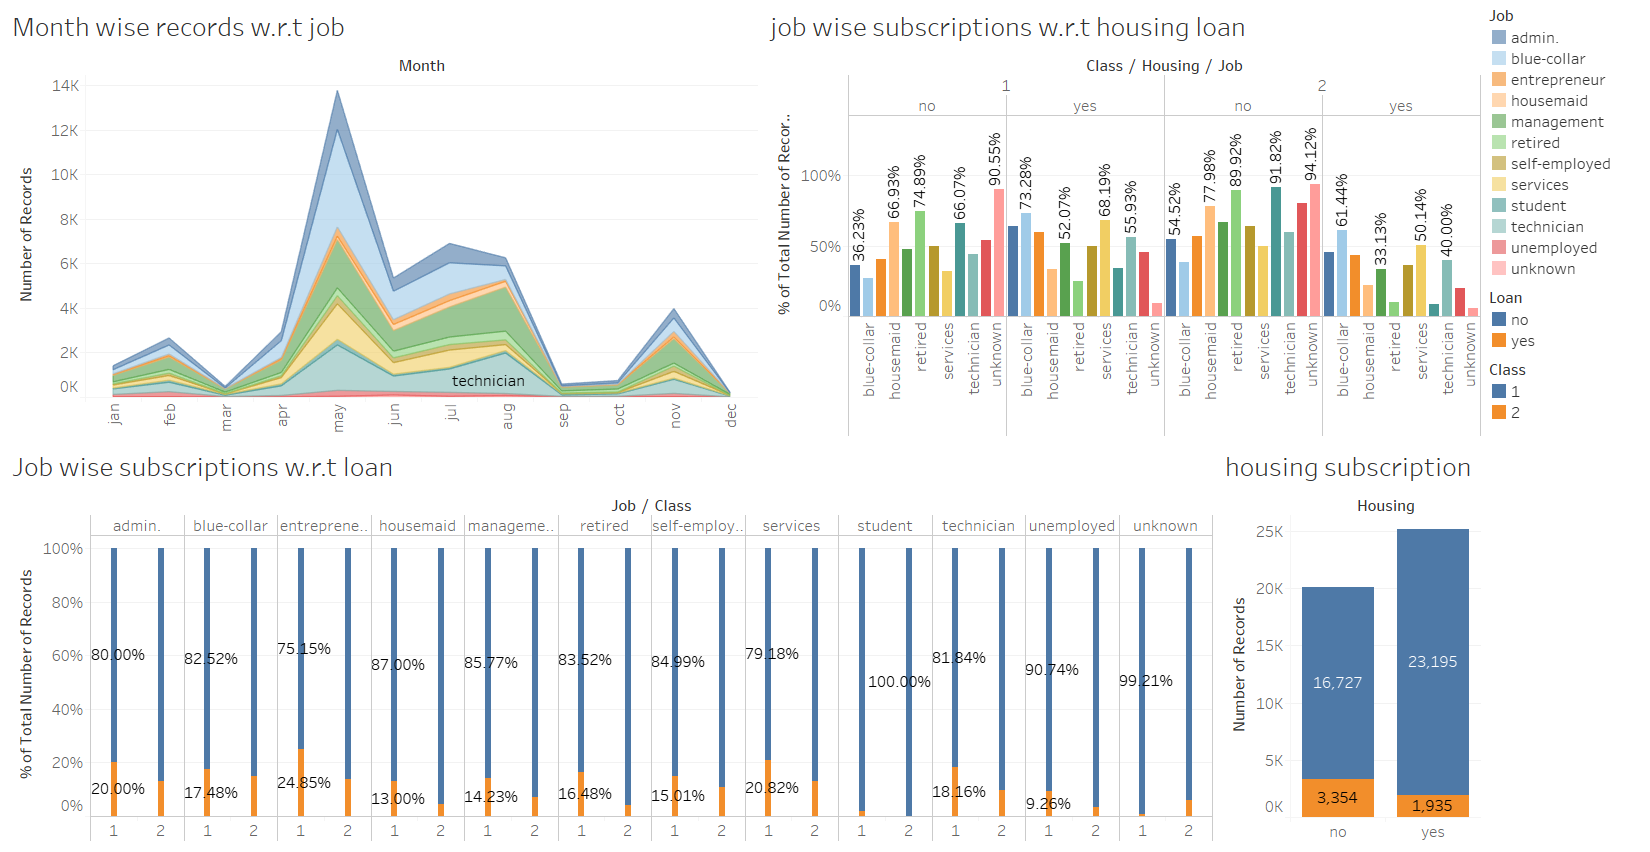

### In the given data it is observed that there are different types of jobs such as admin, management, student, blue collar and others. Among these blue collar job records are high approximately 4,000 and subscription wise also blue collar job holders are doing more term deposits. While considering these job categories bank should also consider housing and personal loan into consideration. 

### From the above graph it is observed that the people with no loan are doing high term deposits compared to people with loan burdens. This signifies that bank should focus on doing marketing on blue collar job holder’s followed by management, admin, and others who are not having loans. This leads to good number of the people turn towards subscriptions.


## 4.2 Visualize the distribution of customer age and balance levels:

In [ ]:
dist_age_balance = plt.figure(figsize = (10,6))
ra1 = dist_age_balance.add_subplot(1,2,1) 
ra2 = dist_age_balance.add_subplot(1,2,2)

ra1.hist(d1['age'],color='orange')
ra1.set_title('The Distribution of Age')

ra2.hist(d1['balance'], color = 'orange')
ra2.set_title('The Distribution of Balance')

plt.tight_layout() 
plt.show()

## The distribution of age:
### In its telemarketing campaigns, clients called by the bank have an extensive age range, from 18 to 95 years old. However, a majority of customers called is in the age of 30s and 40s (33 to 48 years old fall within the 25th to 75th percentiles). 
### The distribution of customer age is fairly normal with a small standard deviation.
## The distribution of balance:
### The distribution of balance having a minimum of -8019 to a maximum of 102127 euros. The distribution of balance has a huge standard deviation relative to the mean, suggesting large variabilities in customers' balance levels.


## 4.3 Visualize the relationship between customer age and balance

In [ ]:
scatter_age_balance = d1.plot.scatter('age','balance',figsize = (7,5))

plt.title('The Relationship between Age and Balance ')
plt.show()

### Based on this scatter plot, there is no clear relationship between client’s age and balance level.
### Nevertheless, over the age of 60, clients tend to have a significantly lower balance, mostly under 5,000 euros. This is due to the fact that most people retire after 60 and no longer have a reliable income source.


## 4.4 Visualize the relationship between phone call duration & the number of campaigns with respect to deposit

In [ ]:
dur_cam = sns.lmplot(x='duration', y='campaign',data = d1,
                     hue = 'deposit',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))

plt.show()

### In this scatter plot, clients not subscribed to term deposits are denoted as "0" while clients subscribed are denoted as "1". Compared to “no” clients”, “yes” clients were contacted by fewer times and had longer call duration. More importantly, after five campaign calls, clients are more likely to reject the term deposit unless the duration is high. Most “yes” clients were approached by less than 10 times. This suggests that the bank should resist calling a client for more than five times, which can be disturbing and increase dissatisfaction.


In [ ]:
d1.drop(['education_un','job_un'],axis=1,inplace=True) # removing created feature required in eda part

## 4.5 Scatter matrix and Correlation matrix

In [ ]:
corr_data = d1
corr = corr_data.corr()
corr

In [ ]:
corr_data = d1
corr = corr_data.corr()

cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.1,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(5,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

### To investigate more about correlation, a correlation matrix was plotted with all qualitative variables. Clearly, “deposit” has a strong correlation with “duration”, a moderate correlation with “pdays”, and mild correlations between “previous”, and “campaign” and “balance”. This correlation matrix also infers that there is no such strong correlation (multi collinearity) among the features and it resembles that there is no much noise in the data.


## 4.6 Visualize the subscription and contact rate by customer age

In [ ]:
lst = [d1]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60


In [ ]:
count_age_response_pct = pd.crosstab(d1['deposit'],d1['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose() 

In [ ]:
age = pd.DataFrame(d1['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_response_pct[1]
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

In [ ]:
plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

## Insights: target the youngest and the oldest instead of the middle-aged
### Green vertical bars indicate that clients with a age of 60+ have the highest subscription rate. About 17% of the subscriptions came from the clients aged between 18 to 29. More than 50% of the subscriptions are contributed by the youngest and the eldest clients.
### It is not surprising to see such a pattern because the main investment objective of older people is saving for retirement while the middle-aged group tend to be more aggressive with a main objective of generating high investment income. Term deposits, as the least risky investment tool, are more preferable to the eldest.
### The youngest may not have enough money or professional knowledge to engage in sophisticated investments, such as stocks and mutual funds. Term deposits provide liquidity and generate interest incomes that are higher than the regular saving account, so term deposits are ideal investments for students.
### However, red vertical bars show that the bank focused its marketing efforts on the middle-aged group, which returned lower subscription rates than the younger and older groups. Thus, to make the marketing campaign more effective, the bank should target younger and older clients in the future


## 4.7 Visualize the subscription rate by balance level

In [ ]:
lst = [d1]
for column in lst:
    column.loc[column["balance"] <= 0,  'balance_group'] = 'no balance'
    column.loc[(column["balance"] > 0) & (column["balance"] <= 1000), 'balance_group'] = 'low balance'
    column.loc[(column["balance"] > 1000) & (column["balance"] <= 5000), 'balance_group'] = 'average balance'
    column.loc[(column["balance"] > 5000), 'balance_group'] = 'high balance'

In [ ]:
count_balance_response_pct = pd.crosstab(d1['deposit'],d1['balance_group']).apply(lambda x: x/x.sum() * 100)
count_balance_response_pct = count_balance_response_pct.transpose()

In [ ]:
bal = pd.DataFrame(d1['balance_group'].value_counts())
bal['% Contacted'] = bal['balance_group']*100/bal['balance_group'].sum()
bal['% Subscription'] = count_balance_response_pct[1]
bal.drop('balance_group',axis = 1,inplace = True)

bal['bal'] = [1,2,0,3]
bal = bal.sort_values('bal',ascending = True)

In [ ]:
plot_balance = bal[['% Subscription','% Contacted']].plot(kind = 'bar',
                                               color = ('royalblue','skyblue'),
                                               figsize = (8,6))

plt.title('Subscription vs Contact Rate by Balance Level')
plt.ylabel('Subscription Rate')
plt.xlabel('Balance Category')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_balance.patches,
                      bal['% Subscription'].round(1).astype(str)):
    plot_balance.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')

## Insights: target clients with average or high balance

### To identify the trend more easily, clients are categorized into four groups based on their levels of balance:
* No Balance: clients with a negative balance.
* Low Balance: clients with a balance between 0 and 1000 euros
* Average Balance: clients with a balance between 1000 and 5000 euros.
* High Balance: clients with a balance greater than 5000 euros.

### Unsurprisingly, this bar chart indicates a positive correlation between clients’ balance levels and subscription rate. Clients with negative balances only returned a subscription rate of 6.9% while clients with average or high balances had significantly higher subscription rates, more than15%.
### However, in this campaign, more than 50% of clients contacted only have a low balance level. In the future, the bank should shift its marketing focus to high-balance customers to secure more term deposits.


## 4.8 Visualize the subscription rate by age and balance

In [ ]:
d1['response']=d1['deposit']
d1['response'].replace(to_replace=[0,1],value=['no','yes'],inplace=True)

In [ ]:
age_balance1 = pd.DataFrame(d1.groupby(['age_group','balance_group'])['deposit'].sum())
age_balance2 = pd.DataFrame(d1.groupby(['age_group','balance_group'])['response'].count())

age_balance1['response'] = age_balance2['response']
age_balance1['response_rate'] = age_balance1['deposit']/ (age_balance1['response'])
age_balance1 = age_balance1.drop(['deposit','response'],axis =1)

age_balance1 = age_balance1.unstack()

In [ ]:
age_bal = age_balance1.plot(kind='bar',figsize = (10,6))

# Set x ticks
plt.xticks(np.arange(5),('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')

# Set legend
plt.legend(['Average Balance','High Balance','Low Balance','No Balance'],loc = 'best',ncol = 1)

plt.ylabel('Subscription Rate')
plt.xlabel('Age Group')
plt.title('The Subscription Rate of Different Balance Levels in Each Age Group')
plt.show()

## Insights: target older clients with high balance levels
### While age represents a person’s life stage and balance represents a person’s financial condition, jointly evaluating the impact of these two factors enables us to investigate if there is a common trend across all ages, and to identify which combination of client features indicates the highest likelihood of subscription.
### In order to investigate the combined effect of age and balance on a client’s decision, we performed a two-layer grouping, segmenting customers according to their balance levels within each age group.
### The graph tells the same story regarding the subscription rate for different age groups: the willingness to subscribe is exceptionally high for people aged above 60 and younger people aged below 30 also have a distinguishable higher subscription rate than those of other age groups.
### Furthermore, the effect of balance levels on subscription decision is applicable to each individual age group: every age group shares a common trend that the percentage of subscription increases with balance.
### In sum, the bank should prioritize its telemarketing to clients who are above 60 years old and have positive balances, because they have the highest acceptance rate of about 35%. The next group the bank should focus on is young clients with positive balances, who showed high subscription rates between 15% and 20%.


## 4.9 Visualize the subscription rate by job

In [ ]:
count_job_response_pct = pd.crosstab(d1['response'],d1['job']).apply(lambda x: x/x.sum() * 100)
count_job_response_pct = count_job_response_pct.transpose()

In [ ]:
plot_job = count_job_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (12,6))
                                                                               
plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')

# Label each bar
for rec, label in zip(plot_job.patches,
                      count_job_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_job.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

## Insights: target students and retired clients
### As noted from the horizontal bar chart, students and retired clients account for more than 50% of subscription, which is consistent with the previous finding of higher subscription rates among the younger and older.


## 4.10 Visualize the subscription and contact rate by month

In [ ]:
#Change 'month' from words to numbers for easier analysis
lst = [d1]
for column in lst:
    column.loc[column["month"] == "jan", "month_int"] = 1
    column.loc[column["month"] == "feb", "month_int"] = 2
    column.loc[column["month"] == "mar", "month_int"] = 3
    column.loc[column["month"] == "apr", "month_int"] = 4
    column.loc[column["month"] == "may", "month_int"] = 5
    column.loc[column["month"] == "jun", "month_int"] = 6
    column.loc[column["month"] == "jul", "month_int"] = 7
    column.loc[column["month"] == "aug", "month_int"] = 8
    column.loc[column["month"] == "sep", "month_int"] = 9
    column.loc[column["month"] == "oct", "month_int"] = 10
    column.loc[column["month"] == "nov", "month_int"] = 11
    column.loc[column["month"] == "dec", "month_int"] = 12

In [ ]:
count_month_response_pct = pd.crosstab(d1['response'],d1['month_int']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()

In [ ]:
month = pd.DataFrame(d1['month_int'].value_counts())
month['% Contacted'] = month['month_int']*100/month['month_int'].sum()
month['% Subscription'] = count_month_response_pct['yes']
month.drop('month_int',axis = 1,inplace = True)

month['Month'] = [5,7,8,6,11,4,2,1,10,9,3,12]
month = month.sort_values('Month',ascending = True)

In [ ]:
plot_month = month[['% Subscription','% Contacted']].plot(kind ='line',
                                                          figsize = (10,6),
                                                          marker = 'o')

plt.title('Subscription vs. Contact Rate by Month')
plt.ylabel('Subscription and Contact Rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of contact
y = month['% Contacted'].max()
x = month['% Contacted'].idxmax()
plt.annotate('May: Peak of contact', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of subscription rate
y = month['% Subscription'].max()
x = month['% Subscription'].idxmax()
plt.annotate('March: Peak Subscription rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()

## Insights: Initiate the telemarketing campaign in fall or spring
### Besides customer characteristics, external factors may also have an impact on the subscription rate, such as seasons and the time of calling. So the month of contact is also analysed here.
### This line chart displays the bank’s contact rate in each month as well as clients’ response rate in each month. One way to evaluate the effectiveness of the bank's marketing plan is to see whether these two lines have a similar trend over the same time horizon.
### The bank contacted most clients between May and August. The highest contact rate is around 30%, which happened in May, while the contact rate is closer to 0 in March, September, October, and December. However, the subscription rate showed a different trend. The highest subscription rate occurred in March, which is over 50%, and all subscription rates in September, October, and December are over 40%.
### Clearly, these two lines move in different directions which strongly indicates the inappropriate timing of the bank’s marketing campaign. To improve the marketing campaign, the bank should consider initiating the telemarketing campaign in fall and spring when the subscription rate tends to be higher.
### Nevertheless, the bank should be cautious when analysing external factors. More data from previous marketing campaign should be collected and analysed to make sure that this seasonal effect is constant over time and applicable to the future.


## Checking the normality of the features

In [ ]:
d2=d1.drop(['age_group','balance_group','response','month_int'],axis=1,inplace=True)

In [ ]:
d2=d1
num_col = ['int16','int32','int64','float16','float32','float64']

#Filter out variables with numeric datatypes
df_numcols_only= d2.select_dtypes(include= num_col)
df_numcols_only.drop(columns=['deposit'],axis=1,inplace=True)

In [ ]:
columns=['age', 'balance', 'day','duration','campaign']
fig,ax = plt.subplots(2,3,figsize=(16,20))
ax = ax.flatten()
for i,col in enumerate(columns):
    sns.distplot(d1[col],ax=ax[i],color='red')
plt.tight_layout()
plt.show()

In [ ]:
d2[['age','balance','duration','campaign','pdays','previous','day']].plot(kind= 'box' ,layout=(4,3),subplots=True, sharex=False, sharey=False, figsize=(20,25),color='blue')
plt.show()

### Before the outlier treatment it is observed form the data is not normally distributed and also many outliers are present in the data. In order to reduce the outliers and to make the data to be normally distributed we identified the outliers and performed knn- imputation on the outlier’s and made outlier treatment.
### In order to reduce the scale of the data we also performed cube root transformation on the data. We choose cube root transformation due to few reasons:
* As data in some of the features are left skewed and square root transformation of left skewed data make data NaN.
* Log transformation in order to reduce the skewness it is increasing the skewness of the some of the features such as “balance” due to the data in the balance feature is left skewed (i.e negative values).

### This makes us to choose higher end transformation techniques such as cube root and finally makes our data normally distributed compared to the data before outlier treatment and transformation.


## Outlyer Treatment and transformation

In [ ]:
num_col = ['int16','int32','int64','float16','float32','float64']

#Filter out variables with numeric datatypes
df_numcols_only1= d2.select_dtypes(include= num_col)

In [ ]:
df_numcols_only1.columns

In [ ]:
d2['age']=zscore(d2['age'])
d2['balance']=zscore(d2['balance'])
d2['duration']=zscore(d2['duration'])
d2['campaign']=zscore(d2['campaign'])
d2['pdays']=zscore(d2['pdays'])
d2['previous']=zscore(d2['previous'])
d2['day']=zscore(d2['day'])

## KNN(Outlayer Treatment)

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
d2.loc[d2.age > 3, 'age'] = np.nan
numeric1=d2[['age']]
imputer = KNNImputer(missing_values=np.nan)
d2['age'] = imputer.fit_transform(numeric1)


d2.loc[d2.age > 3, 'duration'] = np.nan
numeric2=d2[['duration']]
imputer = KNNImputer(missing_values=np.nan)
d2['duration'] = imputer.fit_transform(numeric2)


d2.loc[d2.age > 3, 'campaign'] = np.nan
numeric3=d2[['campaign']]
imputer = KNNImputer(missing_values=np.nan)
d2['campaign'] = imputer.fit_transform(numeric3)


d2.loc[d2.age > 3, 'pdays'] = np.nan
numeric4=d2[['pdays']]
imputer = KNNImputer(missing_values=np.nan)
d2['pdays'] = imputer.fit_transform(numeric4)


d2.loc[d2.age > 3, 'previous'] = np.nan
numeric5=d2[['previous']]
imputer = KNNImputer(missing_values=np.nan)
d2['previous'] = imputer.fit_transform(numeric5)


d2.loc[d2.age > 3, 'day'] = np.nan
numeric6=d2[['day']]
imputer = KNNImputer(missing_values=np.nan)
d2['day'] = imputer.fit_transform(numeric6)

d2.loc[d2.age > 3, 'balance'] = np.nan
numeric7=d2[['balance']]
imputer = KNNImputer(missing_values=np.nan)
d2['balance'] = imputer.fit_transform(numeric7)


d2.loc[d2.age < -3, 'balance'] = np.nan
numeric8=d2[['balance']]
imputer = KNNImputer(missing_values=np.nan)
d2['balance'] = imputer.fit_transform(numeric8)

In [ ]:
d2['age']=np.cbrt(d2['age'])
d2['balance']=np.cbrt(d2['balance'])
d2['duration']=np.cbrt(d2['duration'])
d2['campaign']=np.cbrt(d2['campaign'])
d2['pdays']=np.cbrt(d2['pdays'])
d2['previous']=np.cbrt(d2['previous'])
d2['day']=np.cbrt(d2['day'])

## 4.11 Normality & Outliers of the features after outlier’s treatment

In [ ]:
num_col = ['int16','int32','int64','float16','float32','float64']

#Filter out variables with numeric datatypes
df_numcols_only1= d2.select_dtypes(include= num_col)
df_numcols_only1=df_numcols_only1.columns
df_numcols_only1

In [ ]:
columns=['age', 'balance', 'day','duration','campaign']
fig,ax = plt.subplots(2,3,figsize=(16,20))
ax = ax.flatten()
for i,col in enumerate(columns):
    sns.distplot(d2[col],ax=ax[i])
plt.tight_layout()
plt.show()

In [ ]:
d2[['age','balance','duration','campaign','pdays','previous','day']].plot(kind= 'box' ,layout=(4,3),subplots=True, sharex=False, sharey=False, figsize=(20,25),color='red')
plt.show()

## Dummy Encoding¶


In [ ]:
cat_col=['object']
df_catcols_only=d2.select_dtypes(include=cat_col)

In [ ]:
df_numcols_only.columns

In [ ]:
d2=pd.get_dummies(data=d2,columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],drop_first=True)

In [ ]:
d3=d2

## Part 5 Statistical Analysis
## Statistical tests were performed to see the whether the independent variables have a significant relationship with the dependent variable, DEPOSIT


## 5.1 Chi-square Test
## For the Categorical Columns, a Chi-square Test of independence was performed with the target variable, DEPOSIT which is also a categorical column. 
### Null Hypothesis H0: There is NO association between the two variables 
### Alternate Hypothesis Ha: There is an association between the two variables


In [ ]:
cat_col=['object']
df_catcols_only1=d1.select_dtypes(include=cat_col)

In [ ]:
def chisquare_test(target_variable, categorical_column):
    print('H0: There is NO association between ' + target_variable.name + ' and ' + categorical_column.name)
    print('Ha: There is an association between ' + target_variable.name + ' and ' + categorical_column.name)
    print()
    ct = pd.crosstab(target_variable, categorical_column)
    print(ct)
    chi2_ct = stats.chi2_contingency(ct)
    chival = chi2_ct[0]
    pval = chi2_ct[1]
    print()
    print('chi-val =', chival)
    print('p-val =', pval)
    print()
    rejectH0 = pval < 0.05
    if rejectH0:
        print('Reject H0')
    else:
        print('Failed to reject H0')
    print()
    print('---------------------------------------------------------------')
    return rejectH0

In [ ]:
cat_cols = ['job', 'marital','education','contact','month','poutcome','default','housing','loan']
reject = []
not_reject = []

for col in cat_cols:
    chisquare_test(d1['deposit'], d1[col])
    #if rejectH0:
        #reject.append(col)
    #else:
        #not_reject.append(col)
#print()   
#print('Columns Fails to Reject H0 :', reject)
#print()
#print('Columns Rejected H0 :', not_reject)

## 5.2 Two-sample t test

## For all the numeric variables, A two-sample unpaired t tests was performed between values of the variable for two classes of target variables to compare their means. 
### Null Hypothesis H0: The means of the two samples are EQUAL 
### Alternate Hypothesis Ha: The means of the two samples are NOT EQUAL
## If the means of the two samples are significantly different form each other, then we can conclude that the variable does have a significant relationship with the target variable.


In [ ]:
def two_sample_ttest(target_variable, numerical_column):
    print('H0: The mean of ' + numerical_column.name + ' is equal for both categories of ' + target_variable.name)
    print('Ha: The mean of ' + numerical_column.name + ' is NOT equal for both categories of ' + target_variable.name)
    print()
    grp0 = numerical_column[target_variable == 0]
    grp1 = numerical_column[target_variable == 1]
    ttest = stats.ttest_ind(grp0, grp1)
    print(ttest)
    rejectH0 = ttest[1] < 0.05
    print()
    #return rejectH0
    if rejectH0:
        print('Reject H0')
        print('\n')
        print('-------------------------------------------------------------------------')
    else:
        print('Failed to Reject H0')         
        print()
        print('-------------------------------------------------------------------------')

In [ ]:
num_cols = ['age','balance','day', 'duration', 'campaign', 'pdays', 'previous']

reject = []
not_reject = []
for col in num_cols:
    rejectH0 = two_sample_ttest(d1['deposit'], d1[col])
    """
    if rejectH0:
        reject.append(col)
    else:
        not_reject.append(col)
    
print('Columns Fails to reject H0 :', reject)

print()
print('Columns Reject H0 :', not_reject)"""

## Splitting the data

In [ ]:
X1=d3.drop(columns=['deposit'],axis=1)
y1=d3['deposit']

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1, test_size=0.3, random_state=1)

print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

In [ ]:
import statsmodels.api as sm

In [ ]:
logit_model=sm.Logit(ytrain,Xtrain)
result=logit_model.fit()

In [ ]:
result.summary()

## Removing features which are having p>0.05

### checked the p-values of the features p>0.05 by removing individual features having p>0.05 but changes in the p-value reduction is not observed. So, removing the features all at a time

In [ ]:
X1.drop(columns=['day','previous','job_retired','marital_single','education_secondary','default_yes','contact_telephone','poutcome_other'],axis=1,inplace=True)

## 5.3 check for multicollinearity (VIF)

### Variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
vif= pd.DataFrame()
vif['Features'] = X1.columns
vif['vif']=[variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])]
vif

In [ ]:
vif[vif['vif']>4]

## As only three features are having vif>4 inferes that there is less multicollinearity in the data
## Removing features having vif>4

In [ ]:
X1.drop(['poutcome_unknown','month_may'],axis=1,inplace=True)

In [ ]:
vif= pd.DataFrame()
vif['Features'] = X1.columns
vif['vif']=[variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])]
vif

### From the above results we can infer that the features which are having multicollinearity are only three features. This resembles that there is very less multicollinearity in the data. So there is no need to go for PCA (Principal Component Analysis).

## Part 6 Machine Learning: Classification
### The main objective of this project is to identify the most responsive customers before the marketing campaign so that the bank will be able to efficiently reach out to them, saving time and marketing resources. To achieve this objective, classification algorithms will be employed. By analyzing customer statistics, a classification model will be built to classify all clients into two groups: "yes" to term deposits and "no" to term deposits.


## Prepare Data for Classification
### Select the most relevant customer information: job, education, age, balance, default, housing and loan and other features whose p-value <0.05 and vif<4. Since machine learning algorithms only take numerical values, all five categorical variables (job, education, default, housing and others) are transformed into dummy variables. 

### Dummy variables were used instead of continuous integers because these categorical variables are not ordinal. They simply represent different types rather than levels, so dummy variables are ideal to distinguish the effect of different categories. Feature selection: all customer statistics were selected as features while the deposit feature was set as target. 70% of the data was used to build the classification model and 30% was reserved for testing the model.


In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1, test_size=0.3, random_state=1)

print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(Xtrain, ytrain)

In [ ]:
print('Training score =', model1.score(Xtrain, ytrain))
print('Test score =', model1.score(Xtest, ytest))

In [ ]:
from sklearn.metrics import confusion_matrix
ypred = model1.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
tn = cm[0,0]  #True Negative
tp = cm[1,1]  #True Positives
fp = cm[0,1]  #False Positives
fn = cm[1,0]  #False Negatives

accuracy = (tp+tn)/(tp+fn+fp+tn)
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2*precision*recall / (precision+recall)

print('Accuracy =',accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 Score =', f1)

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
ypred = model1.predict_proba(Xtest)
fpr,tpr,threshold = roc_curve(ytest,ypred[:,1])
roc_auc = roc_auc_score(ytest,ypred[:,1])

print('ROC AUC =', roc_auc)
plt.figure()
lw = 2
plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC Curve (area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## From the above results it is observed that Accuracy is good but precision, recall and f1-score are very less compared to Accuracy. This is due to imbalance in the target variable. So by doing oversampling there is a chance to significantly increase the classification metrics (precision, recall, f1-score) along with accuracy.

## Part 7 Data Imbalance in the Target Varaible

In [ ]:
sns.countplot(ytrain)
plt.xticks(np.arange(2),('Not Made fixed deposit','Made fixed deposit'),rotation=45)
plt.show()
print(ytrain.value_counts())

In [ ]:
didnt = len(d3[d3['deposit'] == 0])
did = len(d3[d3['deposit'] == 1])
total = didnt + did

per_didnt = (didnt / total) * 100
per_did = (did / total) * 100

print(per_didnt)
print(per_did)

## The data is not balanced with approximately 90 and 10 percent .But we can do oversampling. This infers that the target variable is not evenly distributed

## Oversampling the target variable by using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)

X_resampled, y_resampled = sm.fit_sample(X1, y1)

X_resampled = pd.DataFrame(X_resampled, columns=X1.columns)

print(X1.shape)
print(X_resampled.shape)

sns.countplot(y_resampled)
plt.xticks(np.arange(2),('Not Made fixed deposit','Made fixed deposit'),rotation=45)
plt.show()

## Part 8 Base Model with oversampled data (SMOTE)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(X_train, y_train)

In [ ]:
print('Training score =', model1.score(X_train, y_train))
print('Test score =', model1.score(X_test, y_test))

In [ ]:
from sklearn.metrics import confusion_matrix
ypred = model1.predict(X_test)
cm = confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
tn = cm[0,0]  #True Negative
tp = cm[1,1]  #True Positives
fp = cm[0,1]  #False Positives
fn = cm[1,0]  #False Negatives

accuracy = (tp+tn)/(tp+fn+fp+tn)
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2*precision*recall / (precision+recall)

print('Accuracy =',accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 Score =', f1)

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
ypred = model1.predict_proba(Xtest)
fpr,tpr,threshold = roc_curve(ytest,ypred[:,1])
roc_auc = roc_auc_score(ytest,ypred[:,1])

print('ROC AUC =', roc_auc)
plt.figure()
lw = 2
plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC Curve (area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### From the above results it is observed that Accuracy, precision, recall and f1-score are approximately same and all are around 80% which indicates that model is having less bias and variance errors. This is due to generating balance in the target variable by using smote technique. So by doing oversampling the data there is an increase in the classification metrics (precision, recall, f1-score) along with accuracy. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
knn=KNeighborsClassifier()
param={'n_neighbors':np.arange(5,30),'weights':['uniform','distance']}
GS=RandomizedSearchCV(knn,param,cv=3,scoring='f1_weighted',n_jobs=-1)
GS.fit(X_train,y_train)

In [ ]:
GS.best_params_

In [ ]:
dt=DecisionTreeClassifier(random_state=0)

In [ ]:
param={'max_depth':np.arange(3,50),'criterion':['entropy','gini'],'min_samples_leaf':np.arange(3,20)}
GS=RandomizedSearchCV(dt,param,cv=3,scoring='f1_weighted')
GS.fit(X_train,y_train)

In [ ]:
GS.best_params_

In [ ]:
LR=LogisticRegression()
NB=GaussianNB()
KNN=KNeighborsClassifier(n_neighbors=5,weights='distance')
DT=DecisionTreeClassifier(criterion='entropy',max_depth=20,min_samples_leaf=18,random_state=0)
RF=RandomForestClassifier(criterion='entropy',n_estimators=13,random_state=0)
Bag=BaggingClassifier(n_estimators=8,random_state=0)
AB=AdaBoostClassifier(n_estimators=90,random_state=0)
#ABL=AdaBoostClassifier(base_estimator=LR,n_estimators=50,random_state=0)
GB=GradientBoostingClassifier(n_estimators=98)
#svm=SVC(C=10,gamma=0.001,kernel='rbf')
stacked = StackingClassifier(classifiers=[Bag,RF,AB], meta_classifier=KNN)

In [ ]:
RF_var=[]
for val in np.arange(1,50):
  RF=RandomForestClassifier(criterion='gini',n_estimators=val,random_state=0)
  kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
  cv_results = model_selection.cross_val_score(RF, X_train,y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
  RF_var.append(np.var(cv_results,ddof=1))
  

In [ ]:
x_axis=np.arange(1,50)
plt.plot(x_axis,RF_var)

In [ ]:
np.argmin(RF_var)

In [ ]:
Bag_var=[]
for val in np.arange(1,20):
  Bag=BaggingClassifier(n_estimators=val,random_state=0)
  kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
  cv_results = model_selection.cross_val_score(Bag, X_train,y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
  Bag_var.append(np.var(cv_results,ddof=1))
  #print(val,np.var(cv_results,ddof=1))

In [ ]:
x_axis=np.arange(1,20)
plt.plot(x_axis,Bag_var)

In [ ]:
np.argmin(Bag_var)

In [ ]:
Ada_bias=[]
for val in np.arange(1,100):
  Ada=AdaBoostClassifier(n_estimators=val,random_state=0)
  kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
  cv_results = model_selection.cross_val_score(Ada, X_train, y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
  Ada_bias.append(1-np.mean(cv_results))
  #print(val,1-np.mean(cv_results))


In [ ]:
x_axis=np.arange(1,100)
plt.plot(x_axis,Ada_bias)

In [ ]:
np.argmin(Ada_bias)

In [ ]:
GB_bias=[]
for val in np.arange(1,100):
  gb=GradientBoostingClassifier(n_estimators=val)
  kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
  cv_results = model_selection.cross_val_score(gb, X_train, y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
  GB_bias.append(1-np.mean(cv_results))
  #print(val,1-np.mean(cv_results))


In [ ]:
x_axis=np.arange(1,100)
plt.plot(x_axis,GB_bias)

In [ ]:
np.argmin(GB_bias)

## Part 9 Algorithms Comparison:
### Four different classification algorithms (Logistic Regression, K-Neighbours Classifier, Decision Tree Classifier, and Gaussian NB, Random Forest, Ada boost, Gradient Boosting) were run on the dataset through K-fold cross validation and the best-performing one was (identified by observing bias and variance errors) and used to build the classification model.


In [ ]:
models = []
models.append(('Logistic', LR))
models.append(('NaiveBayes', NB))
models.append(('KNN',KNN))
models.append(('DecisionTree',DT))
models.append(('RandomForest',RF))
models.append(('BaggingClassifier',Bag))
models.append(('AdaBoost',AB))
models.append(('GBoost',GB))
models.append(('Stacked',stacked))

In [ ]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
	cv_results = model_selection.cross_val_score(model, X_train, y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
	results.append(cv_results)
	names.append(name)
	print("%s: %f (%f)" % (name, np.mean(cv_results),np.var(cv_results,ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure(figsize=(10,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names,rotation=45)
plt.show()

## From the above results it is observed that RF Classifier is the best performing model.
### By comparing all algorithms bias error and variance error, RF classifier is observed to be the best so it would be used to predict term depositor’s. The test of RF classifier with base estimator (Decision Tree (DEFAULT), n_estimators=13) is the best model with best bias & variance error trade off


In [ ]:
RF.fit(X_train,y_train)

In [ ]:
print('Training score =', RF.score(X_train, y_train))
print('Test score =', RF.score(X_test, y_test))

In [ ]:
predictions = RF.predict(X_test)

In [ ]:
print(accuracy_score(y_test, predictions))

In [ ]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_test, predictions))

In [ ]:
tn = cm[0,0]  #True Negative
tp = cm[1,1]  #True Positives
fp = cm[0,1]  #False Positives
fn = cm[1,0]  #False Negatives

accuracy = (tp+tn)/(tp+fn+fp+tn)
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2*precision*recall / (precision+recall)

print('Accuracy =',accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 Score =', f1)

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
ypred = RF.predict_proba(Xtest)
fpr,tpr,threshold = roc_curve(ytest,ypred[:,1])
roc_auc = roc_auc_score(ytest,ypred[:,1])

print('ROC AUC =', roc_auc)
plt.figure()
lw = 2
plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC Curve (area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Finally

In [ ]:
RF.fit(X1,y1)

## Part 10 Conclusion
### The main objective of this project is to increase the effectiveness of the bank's telemarketing campaign, which was successfully met through data analysis, visualization and analytical model building. A target customer profile was established while classification models were built to predict customers' response to the term deposit campaign.
### According to previous analysis, a target customer profile can be established. The most responsive  customers possess these features:

* Feature 1: age < 30 or age > 60
* Feature 2: students or retired people
* Feature 3: a balance of more than 5000 euros

### By applying RF classifier algorithm, classification and estimation model were successfully built. With this model, the bank will be able to predict a customer's response to its telemarketing campaign before calling this customer. In this way, the bank can allocate more marketing efforts to the clients who are classified as highly likely to accept term deposits, and call less to those who are unlikely to make term deposits.
### In addition, predicting duration before calling and adjusting marketing plan benefit both the bank and its clients. On the one hand, it will increase the efficiency of the bank’s telemarketing campaign, saving time and efforts. On the other hand, it prevents some clients from receiving undesirable advertisements, raising customer satisfaction. With the aid of RF classifier model, the bank can enter a virtuous cycle of effective marketing, more investments and happier customers.

## Part 11 Recommendations
## 11.1. More appropriate timing
### When implementing a marketing strategy, external factors, such as the time of calling, should also be carefully considered. The previous analysis points out that March, September, October and December had the highest success rates. Nevertheless, more data should be collected and analyzed to make sure that this seasonal effect is constant over time. If the trend has the potential to continue in the future, the bank should consider initiating its telemarketing campaign in fall and spring.
## 11.2. Smarter marketing design
### By targeting the right customers, the bank will have more and more positive responses, and the classification algorithms would ultimately eliminate the imbalance in the original dataset. Hence, more accurate information will be presented to the bank for improving the subscriptions. Meanwhile, to increase the likelihood of subscription, the bank should re-evaluate the content and design of its current campaign, making it more appealing to its target customers.
## 11.3. Better services provision
### With a more granular understanding of its customer base, the bank has the ability to provide better banking services. For example, marital status and occupation reveal a customer's life stage while loan status indicates his/her overall risk profile. With this information, the bank can estimate when a customer might need to make an investment. In this way, the bank can better satisfy its customer demand by providing banking services for the right customer at the right time.
